In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from utils import Processor, EnsembleClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
import telepot
%matplotlib inline

from sklearn import svm,cross_validation,tree,linear_model,preprocessing,metrics
from sklearn.mixture import GMM
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB

In [2]:
# os.chdir('/')
trainFid = 'KDDTrain+.txt'
testFid = 'KDDTest-21.txt'
bot = telepot.Bot('258510570:AAHujlmQqiZ_L4yrWMR9HtuE-0rK8xXo-XY')

## 資料前處理

In [3]:
traindata, attack_type_list = Processor.cleanData(trainFid)
traindata = traindata.iloc[np.random.permutation(len(traindata))]
test_data_len = 20000
traindata_len = len(traindata) - test_data_len
testdata = traindata[traindata_len - test_data_len:]
traindata = traindata[:traindata_len - test_data_len]
# testdata, _ = Processor.cleanData(testFid)
traindata.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
16318,0,tcp,shell,S0,0,0,0,0,0,0,...,1,0.00,0.08,0.00,0.0,1.0,1.0,0.0,0.0,1
56312,0,tcp,ftp_data,SF,768,0,0,0,0,0,...,22,0.41,0.06,0.41,0.0,0.0,0.0,0.0,0.0,0
35233,0,tcp,time,S0,0,0,0,0,0,0,...,18,0.07,0.06,0.00,0.0,1.0,1.0,0.0,0.0,1
25521,37183,tcp,private,RSTR,1,0,0,0,0,0,...,2,0.01,0.50,1.00,0.0,0.0,0.0,1.0,1.0,3
64055,0,tcp,http,SF,249,1931,0,0,0,0,...,255,1.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0


##### 列出一些基本資料

In [4]:
print "攻擊型態：%s" % attack_type_list
print "有%d筆訓練資料" % len(traindata)
print "有%d筆測試資料" % len(testdata)

攻擊型態：['normal', 'dos', 'r2l', 'probe', 'u2r']
有85973筆訓練資料
有40000筆測試資料


##### 資料的特徵及屬性

In [5]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85973 entries, 16318 to 54165
Data columns (total 42 columns):
duration                       85973 non-null int64
protocol_type                  85973 non-null object
service                        85973 non-null object
flag                           85973 non-null object
src_bytes                      85973 non-null int64
dst_bytes                      85973 non-null int64
land                           85973 non-null int64
wrong_fragment                 85973 non-null int64
urgent                         85973 non-null int64
hot                            85973 non-null int64
num_failed_logins              85973 non-null int64
logged_in                      85973 non-null int64
num_compromised                85973 non-null int64
root_shell                     85973 non-null int64
su_attempted                   85973 non-null int64
num_root                       85973 non-null int64
num_file_creations             85973 non-null int64


#### 1. 檢視攻擊種類分佈

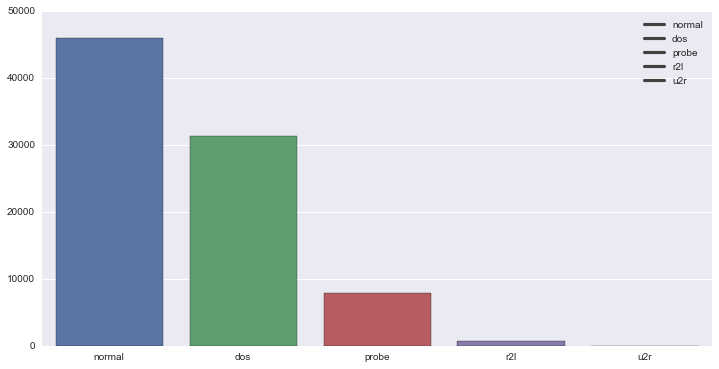

In [6]:
plt.figure(figsize = (12, 6))
ax = sns.barplot(x=range(0, len(traindata['attack_type'].value_counts())), y=traindata['attack_type'].value_counts().tolist())
attack_t = [attack_type_list[i] for i in traindata['attack_type'].value_counts().index]
plt.legend(attack_t,loc=0)
ax.set_xticklabels(attack_t)

#### 2. 資料標準化

In [7]:
data_all = pd.concat([traindata, testdata])
traindata_df = pd.get_dummies(
    Processor.normalize(data_all.drop(['attack_type'], axis=1)))[:len(traindata)]
testdata_df = pd.get_dummies(
    Processor.normalize(data_all.drop(['attack_type'], axis=1)))[len(traindata):]
traindata_df['attack_type'] = traindata['attack_type']
testdata_df['attack_type'] = testdata['attack_type']
anomalydata_df = traindata_df[traindata_df['attack_type']!=0]
anomalydata_df.index = range(0, len(anomalydata_df))
normaldata_df = traindata_df[traindata_df['attack_type']==0]
normaldata_df.index = range(0, len(normaldata_df))

In [8]:
normaldata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
0,-0.110249,-0.007631,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,-0.110249,-0.007720,-0.004438,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,1.235689,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,-0.110249,-0.007731,-0.004813,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,1.235689,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,-0.110249,-0.007761,-0.004797,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,-0.110249,-0.007749,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [9]:
anomalydata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
0,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,14.166112,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
4,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [10]:
testdata.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
118144,0,udp,domain_u,SF,46,81,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0
58211,0,tcp,private,RSTR,0,0,0,0,0,0,...,1,0.00,0.63,0.63,0.00,0.00,0.0,0.62,1.00,3
16521,0,tcp,private,S0,0,0,0,0,0,0,...,6,0.02,0.05,0.00,0.00,1.00,1.0,0.00,0.00,1
74570,0,tcp,finger,SF,9,147,0,0,0,0,...,10,0.05,0.08,0.03,0.30,0.00,0.0,0.00,0.00,0
106598,0,tcp,smtp,RSTO,0,0,0,0,0,0,...,109,0.33,0.11,0.19,0.02,0.01,0.0,0.42,0.01,3


#### 3. 異常資料分群

In [11]:
K = 3
kmeans = KMeans(n_clusters=K, random_state=0).fit(anomalydata_df.iloc[:,:anomalydata_df.shape[1]-1])
clustors = kmeans.predict(anomalydata_df.iloc[:,:anomalydata_df.shape[1]-1])

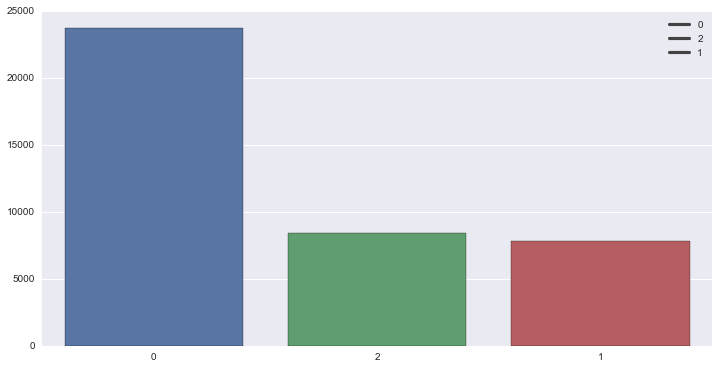

In [12]:
plt.figure(figsize = (12, 6))
ax = sns.barplot(x=range(0, len(pd.Series(clustors).value_counts())), y=pd.Series(clustors).value_counts().tolist())
plt.legend(pd.Series(clustors).value_counts().index.tolist(),loc=0)
ax.set_xticklabels(pd.Series(clustors).value_counts().index.tolist())

In [13]:
try:
    anomalydata_df = anomalydata_df.drop(['clusters'], axis = 1)
except:
    pass
anomalydata_df.insert(0, 'clusters', pd.Series(clustors, dtype=np.int64))

In [14]:
cluster_df = []
for cluster in sorted(anomalydata_df['clusters'].unique()):
    node = anomalydata_df[anomalydata_df['clusters']==cluster]
    node = node.drop(['clusters'], axis=1)
    cluster_df.append(node)

In [15]:
cluster_df[2]['attack_type'].value_counts().sort_index()

1    4740
2      37
3    3667
Name: attack_type, dtype: int64

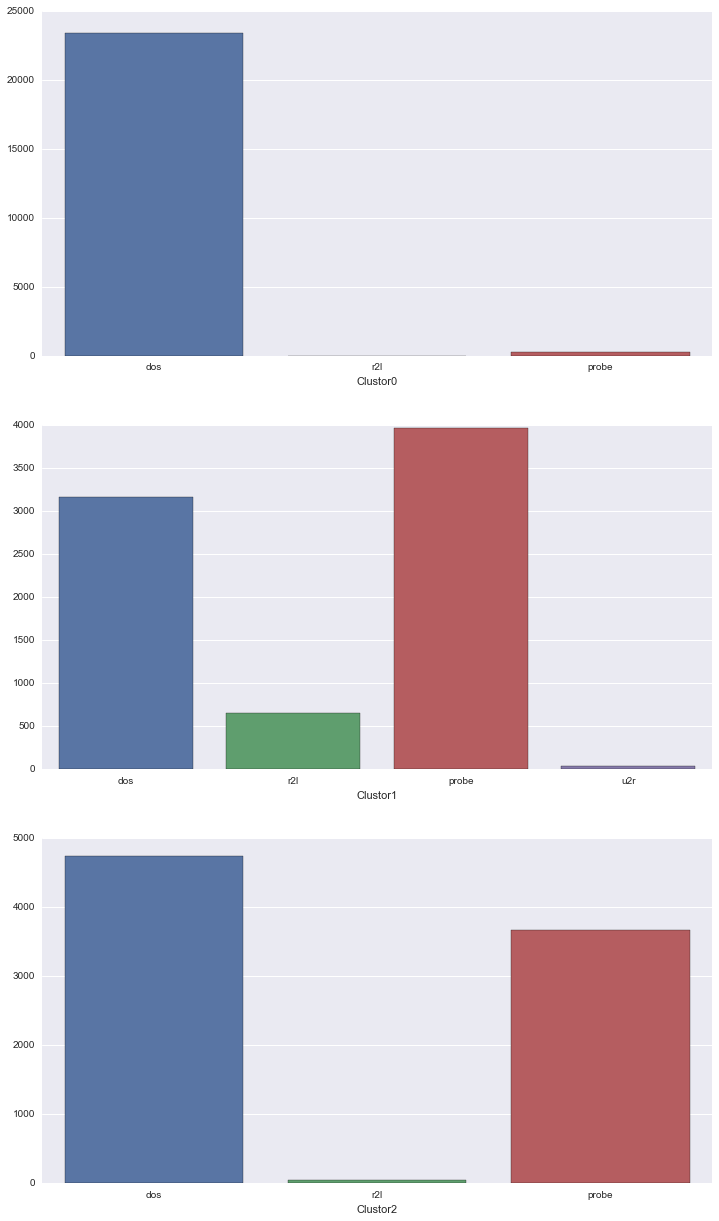

In [16]:
fig, ax = plt.subplots(len(cluster_df), 1, figsize = (12, len(cluster_df) * 7))
for index, cluster in enumerate(cluster_df):
    sns.barplot(x=range(0, len(cluster['attack_type'].value_counts()))\
                     , y=(cluster['attack_type'].value_counts().sort_index()).tolist()\
                     , ax = ax[index])
    attack_t = [attack_type_list[i] for i in cluster['attack_type'].value_counts().sort_index().index]
    ax[index].set_xticklabels(attack_t)
    ax[index].set_xlabel("Clustor%d" % index)

#### 4. 正常資料與異常合併

In [17]:
for index in range(0, len(cluster_df)):
    df = pd.concat([cluster_df[0], normaldata_df], ignore_index = True)
    cluster_df[index] = pd.concat([cluster_df[index], normaldata_df], ignore_index = True)
    cluster_df[index] = cluster_df[index].iloc[np.random.permutation(len(cluster_df[index]))]
    cluster_df[index].index = range(0, len(cluster_df[index]))

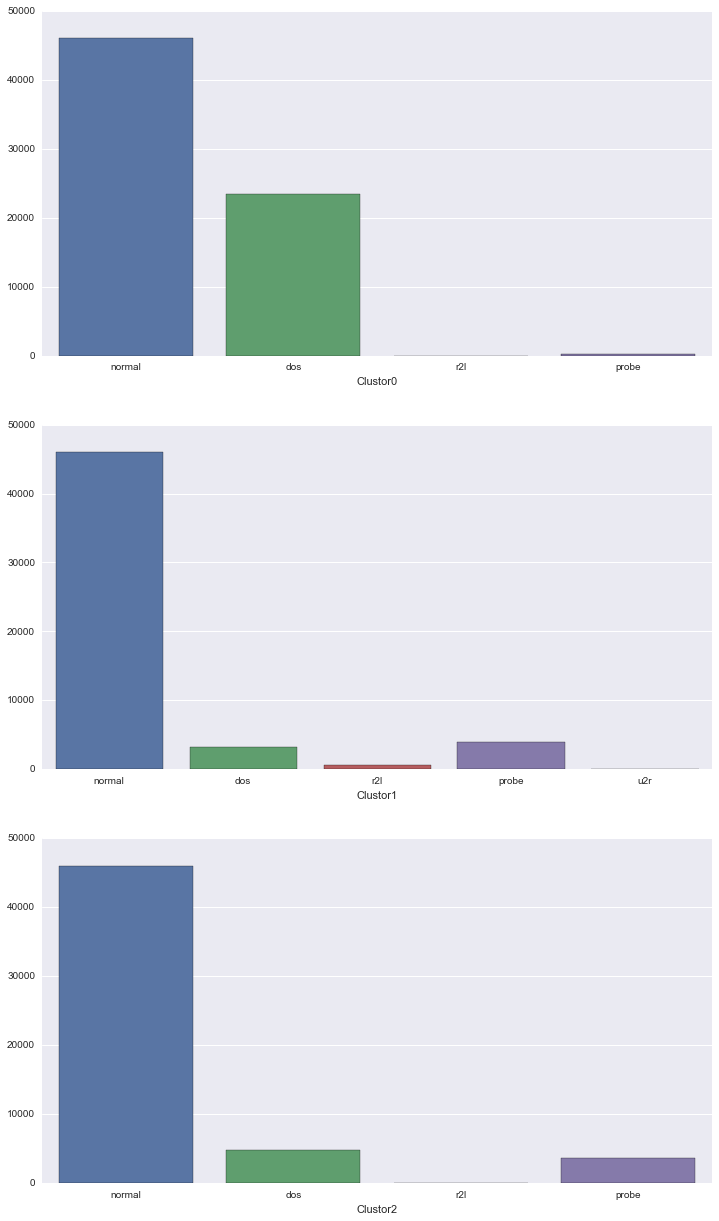

In [18]:
fig, ax = plt.subplots(len(cluster_df), 1, figsize = (12, len(cluster_df) * 7))
for index, cluster in enumerate(cluster_df):
    sns.barplot(x=range(0, len(cluster['attack_type'].value_counts().sort_index()))\
                     , y=(cluster['attack_type'].value_counts().sort_index()).tolist()\
                     , ax = ax[index])
    attack_t = [attack_type_list[i] for i in cluster['attack_type'].value_counts().sort_index().index]
    ax[index].set_xticklabels(attack_t)
    ax[index].set_xlabel("Clustor%d" % index)

## 針對資料進行學習

#### 1. 最簡單的分類器

In [19]:
traindata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
16318,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
56312,-0.110249,-0.007631,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
35233,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
25521,14.166112,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
64055,-0.110249,-0.007720,-0.004438,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,1.235689,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [20]:
testdata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
118144,-0.110249,-0.007754,-0.004898,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
58211,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
16521,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
74570,-0.110249,-0.007761,-0.004882,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
106598,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


###### 新增一個對照組 (利用決策樹)

In [21]:
def score(m):
    tp = m[0][0]
    fp = m[0][1]
    fn = m[1][0]
    tn = m[1][1]
    f1_score = 2. * tp / (2 * tp + fp + fn)
    accuracy = float(tp + tn) / (tp + fp + tn +fn)
    
    return accuracy, f1_score
def plot_confusion_matrix(cm, title='Confusion Metrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = range(0, 2)
    plt.xticks(tick_marks, ['normal', 'anomaly'], rotation=45)
    plt.yticks(tick_marks, ['normal', 'anomaly'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

準確度：0.695550
F1 Score：0.671522


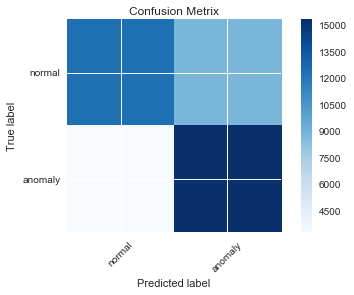

In [22]:
train_x = traindata_df.drop(['attack_type'], axis = 1).values
train_y = traindata_df['attack_type'].values
test_x = testdata_df.drop(['attack_type'], axis = 1).values
answer = testdata_df['attack_type'].values
answer = np.array([0 if a == 0 else 1 for a in answer])
tree = GaussianNB()
tree.fit(train_x, train_y)
predict = tree.predict(test_x)
predict = np.array([0 if p == 0 else 1 for p in predict])

cfu_metrix = metrics.confusion_matrix(answer, predict)
accuracy, f1_score = score(cfu_metrix)

print "準確度：%f" % accuracy
print "F1 Score：%f" % f1_score

plt.figure()
plot_confusion_matrix(metrics.confusion_matrix(answer, predict))

###### 分層訓練

In [23]:
en_clf_list = []
for index in range(0, len(cluster_df)):
    clf_cluster = [
        LogisticRegression(),
        DecisionTreeClassifier(),
        GaussianNB(),
        AdaBoostClassifier()
    ]
    
    train_y = cluster_df[index]['attack_type'].values
    train_x = cluster_df[index].drop(['attack_type'], axis = 1).values
    
    en = EnsembleClassifier(clf_cluster)
    en.fit(train_x, train_y)
    en_clf_list.append(en)

###### 分層預測

In [ ]:
test_x = testdata_df.drop(['attack_type'], axis = 1).values
answer = testdata_df['attack_type'].values
prediction = []
normal_index = []

for index in range(0, len(en_clf_list)):
    predict = en_clf_list[index].predict(test_x)
    normal_index.append(np.where(predict == attack_type_list.index('normal'))[0])
    
    test_x = test_x[normal_index[index]]
    answer = answer[normal_index[index]]

In [ ]:
answer = testdata_df['attack_type'].values
pre = normal_index[0][normal_index[1][normal_index[2]]]
predict = []
for i in range(0, len(answer)):
    if i in pre:
        predict.append(attack_type_list.index('normal'))
    else:
        predict.append(1)
predict = np.array(predict)
answer = np.array([0 if a == 0 else 1 for a in answer])

##### 經過多層次分類器預測後的準確機率

In [ ]:
# 預測準確的資料長度 / 測試資料的長度
cfu_metrix = metrics.confusion_matrix(answer, predict)
accuracy, f1_score = score(cfu_metrix)

print "準確度：%f" % accuracy
print "F1 Score：%f" % f1_score
plt.figure()
plot_confusion_matrix(metrics.confusion_matrix(answer, predict))

In [ ]:
bot.sendMessage('252175743', '多層次分類器運算完了')